![](imagenes/unaj_logo.png)

*Maestría en Ciencia de Datos*

*Instituto de Ingeniería y Agronomía*

# Trabajo Integrador: Programación

## Integrantes

- Facundo Cuba
- Leticia Nanini
- Mauro Cejas Marcovecchio
- Yesica Travasso

## Descripción

El objetivo del proyecto es desarrollar un sistema de gestión académica que permita analizar las notas de los estudiantes en diferentes asignaturas. Dicho sistema será capaz de calcular el promedio de notas, determinar la situación académica de cada estudiante (aprobado o reprobado) y mostrar la información general de las notas. 

## Modelado orientado a datos

### Estructura

En primer lugar, vamos a tomar la definición de dividir nuestro código en módulos, haciéndolo más fácil de mantener, escalar y nos permite separar las distintas etapas necesarias para el objetivo del trabajo.

De esa forma, la organización del trabajo será la siguiente:

In [14]:
# Si todavía no fue instalado, se debe correr el código: pip install anytree

from anytree import Node, RenderTree

# Creamos los Nodos

raiz = Node('proyecto/')
nodo_b = Node('notebook.ipynb', parent=raiz)
nodo_c = Node('datos/', parent=raiz)
nodo_d = Node('modelos/', parent=raiz)
nodo_e = Node('analisis/', parent=raiz)
nodo_f = Node('generador_datos.py', parent=nodo_c)
nodo_g = Node('procesamiento.py', parent=nodo_c)
nodo_h = Node('entidades.py', parent=nodo_d)
nodo_i = Node('estadisticas.py', parent=nodo_e)

# Función para imprimir el árbol

for pre, fill, node in RenderTree(raiz):
    print("%s%s" % (pre, node.name))

proyecto/
├── notebook.ipynb
├── datos/
│   ├── generador_datos.py
│   └── procesamiento.py
├── modelos/
│   └── entidades.py
└── analisis/
    └── estadisticas.py


### Creación de datos

Cada vez que necesitemos crear una nueva base de datos de estudiantes y sus respectivas notas de materias académicas de forma aleatoria, vamos a llamar a la función diseñada específicamente para esa tarea. 

Según la cantidad de estudiantes que definamos, se crearán aleatoriamente nombres, apellidos y notas del 1 al 10 de las siguientes materias:

- Matemáticas
- Física
- Química
- Biología
- Literatura
- Historia
- Geografía
- Economía
- Inglés
- Artes
- Educación Física
- Computación

In [32]:
from datos.generador_datos import generar_csv_estudiantes

# Solicitar entrada al usuario
while True:
    try:
        n = int(input("Ingrese el número de estudiantes a generar: "))
        if n > 0:
            generar_csv_estudiantes(n)
            print(f"Archivo generado con {n} estudiantes.")
            break
        else:
            print("¡Error! Ingrese un número mayor que cero.")
    except ValueError:
        print("¡Error! Debe ingresar un número entero.")

Archivo generado con 325 estudiantes.


## Lectura y Procesamiento de datos

De esta manera, podemos chequear que los datos se hayan generado correctamente y tener un primer acercamiento a su visualización mediante el paquete Pandas:

In [3]:
import pandas as pd

pd.read_csv('estudiantes.csv').head()

,nombre,apellido,matemáticas,física,química,biología,literatura,historia,geografía,economía,inglés,artes,edu_fisica,computación
0,Vinicio,Girón,10,6,1,6,7,2,7,10,4,6,2,6
1,Custodia,Agudo,2,5,5,6,5,5,1,1,3,1,4,7
2,Samuel,Alberdi,2,10,1,1,9,10,8,3,2,3,7,3
3,Anacleto,Maldonado,1,8,3,9,7,4,4,8,6,5,10,8
4,Ceferino,Cabezas,10,10,6,5,1,10,10,9,9,4,8,4


Aún así, vamos a procesar los datos de otra manera. Partiendo de las definiciones de las clases del módulo *entidades.py*, tendremos un nombre y apellido para cada Estudiante, junto a una lista de cada Materia, que contendrá su nombre y la nota obtenida. A su vez, se definirá una función para calcular el promedio de todas las materias obtenido por cada estudiante.

In [4]:
from datos.procesamiento import procesar_csv

estudiantes = procesar_csv('estudiantes.csv')

# Mostrar los primeros 5 estudiantes para verificar el resultado
for estudiante in estudiantes[:5]:
	print(estudiante)

Vinicio Girón - Promedio: 5.58
Custodia Agudo - Promedio: 3.75
Samuel Alberdi - Promedio: 4.92
Anacleto Maldonado - Promedio: 6.08
Ceferino Cabezas - Promedio: 7.17


## Análisis Académico

In [5]:
from analisis.estadisticas import calcular_estadisticas_grupo

estadisticas = calcular_estadisticas_grupo(estudiantes)


## Presentación de Resultados

**Rendimiento académico de cada estudiante**

In [ ]:
for i, estudiante in enumerate(estudiantes, 1):
    print(f"\nEstudiante #{i}")
    print(estudiante)
    print("Detalle de materias:")
    for materia in estudiante.materias:
        estado = "Aprobada" if materia.aprobada() else "Reprobada"
        print(f"- {materia.nombre}: {materia.nota} ({estado})")

**Estadísticas generales del grupo**

In [6]:
print("\nPromedio por asignatura:")
for materia, promedio in estadisticas['promedios'].items():
    print(f"- {materia.capitalize()}: {promedio:.2f}")

print(f"\nPorcentaje de aprobación general: {estadisticas['porcentaje_aprobacion']:.2f}%")

print("\nAsignaturas con mayor y menor rendimiento:")
print(f"- Mayor rendimiento: {estadisticas['mejor_rendimiento'][0].capitalize()} ({estadisticas['mejor_rendimiento'][1]:.2f})")
print(f"- Menor rendimiento: {estadisticas['peor_rendimiento'][0].capitalize()} ({estadisticas['peor_rendimiento'][1]:.2f})")


Promedio por asignatura:
- Matemáticas: 5.62
- Física: 5.44
- Química: 5.28
- Biología: 5.32
- Literatura: 5.23
- Historia: 5.35
- Geografía: 5.59
- Economía: 5.45
- Inglés: 5.67
- Artes: 5.36
- Edu_fisica: 5.38
- Computación: 5.14

Porcentaje de aprobación general: 48.10%

Asignaturas con mayor y menor rendimiento:
- Mayor rendimiento: Inglés (5.67)
- Menor rendimiento: Computación (5.14)


**Visualización gráfica**

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

plt.style.use('seaborn-v0_8')
nombres_materias = [materia.nombre for materia in estudiantes[0].materias]

# Generar un gráfico por materia
for i, materia_nombre in enumerate(nombres_materias):
    notas = [e.materias[i].nota for e in estudiantes]
    promedio, std_dev = np.mean(notas), np.std(notas)
    
    plt.figure(figsize=(10, 6))
    # Crear distribución normal teórica
    x = np.linspace(0, 10, 1000)
    y = norm.pdf(x, promedio, std_dev)
    
    # Graficar
    plt.plot(x, y, 'b-', linewidth=2, label='Distribución teórica')
    plt.fill_between(x, y, color='blue', alpha=0.1)
    
    # Graficar histograma de datos reales
    plt.hist(notas, bins=10, density=True, alpha=0.5, color='green', label='Datos reales')
    
    # Línea vertical para el promedio
    plt.axvline(promedio, color='red', linestyle='--', linewidth=2, label=f'Promedio: {promedio:.2f}')
    
    # Configuración del gráfico
    plt.title(f'Distribución de notas en {materia_nombre.capitalize()}\n'
             f'Promedio: {promedio:.2f} - Desviación: {std_dev:.2f}')
    plt.xlabel('Notas')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 10)

    # Mostrar gráfico
    plt.tight_layout()
    plt.show()

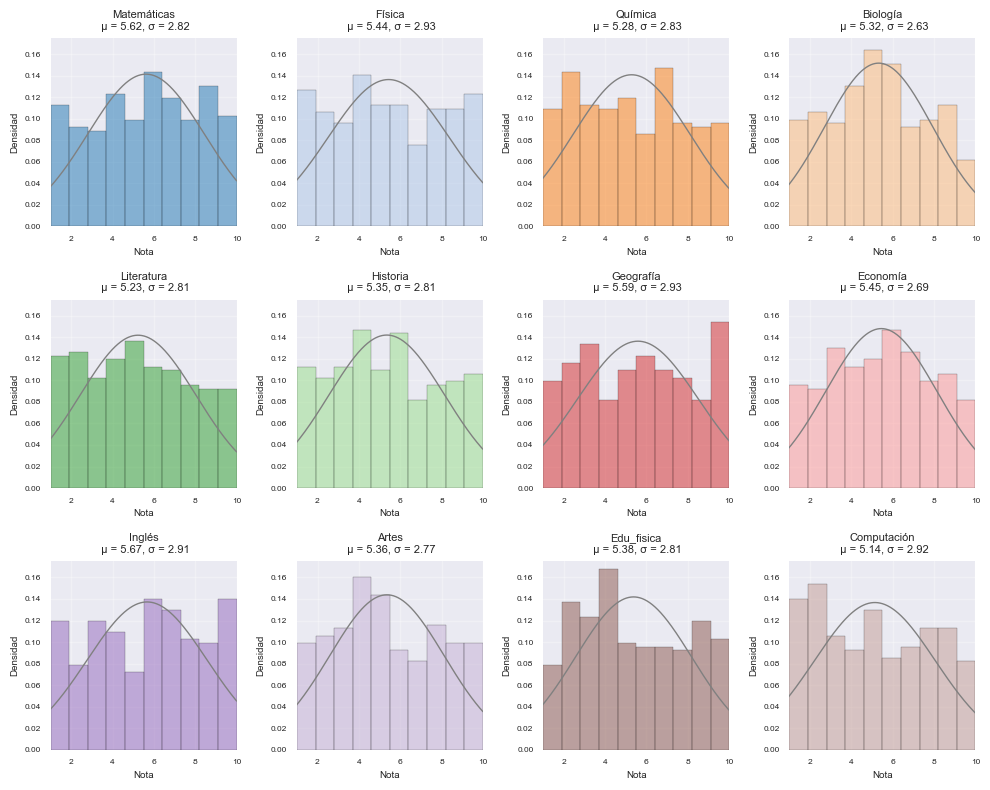

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# Seteamos el número de histogramas, filas y columnas a mostrar
num_hist = 12

num_filas = 3
num_cols = 4

# Creamos la figura y los subplots
fig, axes = plt.subplots(num_filas, num_cols, figsize=(10, 8))

# Convertimos los ejes a un arreglo unidimensional para facilitar la iteración
axes_flat = axes.flatten()

# Generamos una lista de 12 colores distintos desde colormap
colors = plt.cm.tab20.colors[:num_hist]

for i, (materia_nombre, ax) in enumerate(zip(nombres_materias, axes_flat)):
    notas = [e.materias[i].nota for e in estudiantes]
    promedio, std_dev = np.mean(notas), np.std(notas)

    ax.hist(notas, bins=10, density=True, alpha=0.5, color=colors[i], edgecolor='black', label='Datos reales')

     # Distribución normal teórica (solo línea negra fina)
    x = np.linspace(0, 10, 1000)
    y = norm.pdf(x, promedio, std_dev)
    ax.plot(x, y, color='gray', linewidth=1, label='Dist. normal')

    # Graficamos el histograma
    
    ax.set_title(f'{materia_nombre.capitalize()}\n μ = {promedio:.2f}, σ = {std_dev:.2f}', fontsize=8)
    ax.set_xlabel('Nota', fontsize=7)
    ax.set_ylabel('Densidad', fontsize=7)
    ax.tick_params(axis='both', labelsize=6)
    ax.set_xlim(1, 10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 0.175)


    
# Eliminar subplots vacíos si sobran
for j in range(num_hist, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

